## Imports, train_test loop, saliency map plotting function, training loss plotting function, dataloader

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import os

class CustomDataset(Dataset):
    def __init__(self, img_folder, labels_file, transform=None,label_type=""):
        if(not(label_type=="hour" or label_type=="min")): raise Exception("Not valid label type")
        self.img_folder = img_folder
        self.labels_df = pd.read_csv(labels_file, header=None)
        self.transform = transform
        self.label_type=label_type

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_folder, f"{idx}.jpg")  # Image file names start from 0.png
        image = Image.open(img_name)
        if(self.label_type=="hour"):
            label = self.labels_df.iloc[idx, 0]  # Format label as hour:minute
        elif(self.label_type=="min"):
            label = self.labels_df.iloc[idx, 1]  # Format label as hour:minute
        if self.transform:
            image = self.transform(image)

        # return transforms.ToTensor()(image), label
        return image,label

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),           # Convert image to PyTorch tensor
    # transforms.Normalize()  # Normalize image
])

# Path to the folder containing images
img_folder = "Naman/analog_clocks/images"

# Path to the labels CSV file
labels_file = "Naman/analog_clocks/label.csv"
# Create the custom dataset
hour_custom_dataset = CustomDataset(img_folder=img_folder, labels_file=labels_file, transform=transform,label_type="hour")
min_custom_dataset = CustomDataset(img_folder=img_folder, labels_file=labels_file, transform=transform,label_type="min")




6


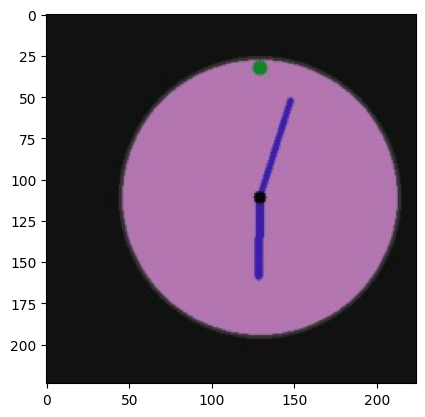

In [2]:
i=132
inp = hour_custom_dataset.__getitem__(i)[0]
print(hour_custom_dataset.__getitem__(i)[1])
plt.imshow(inp.permute(1,2,0))

In [15]:

# Define the size of the training and testing sets
train_size = int(0.5 * len(min_custom_dataset))
test_size = len(min_custom_dataset) - train_size

# Split the dataset randomly into training and testing sets
train_dataset, test_dataset = random_split(min_custom_dataset, [train_size, test_size])

# Example of accessing the length of the train and test datasets
print("Training dataset size:", len(train_dataset))
print("Testing dataset size:", len(test_dataset))




# Example usage of the dataset
# Access the first image and its label
image, label = min_custom_dataset[0]
print("Label:", label)
print("Image shape:", image.shape)

# Create a DataLoader to load the dataset in batches
batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Example usage of the data loader
for images, labels in train_data_loader:
    # Training loop or any other processing here
    print("Batch Images shape:", images.shape)
    print("Batch Labels:", labels)
    break  # Break after the first batch

Training dataset size: 25000
Testing dataset size: 25000
Label: 2
Image shape: torch.Size([3, 224, 224])
Batch Images shape: torch.Size([32, 3, 224, 224])
Batch Labels: tensor([32, 33, 12, 18,  0, 29, 37, 44, 48,  8,  0, 10, 50, 19,  9, 23, 55, 16,
        59,  9, 42, 44, 49, 11, 32, 44, 51, 41, 57, 38, 48, 26])


tensor(59)


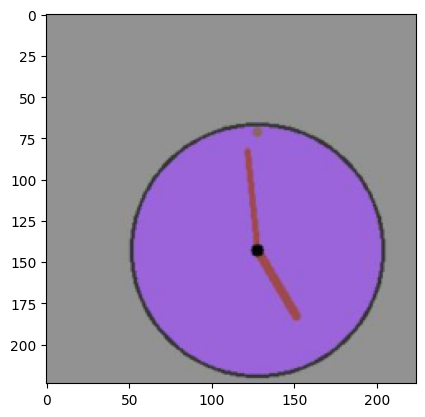

In [16]:
for inputs,labels in test_data_loader:
    x = inputs[0]
    y = labels[0]

    plt.imshow(x.permute(1,2,0))
    print(y)
    break

36


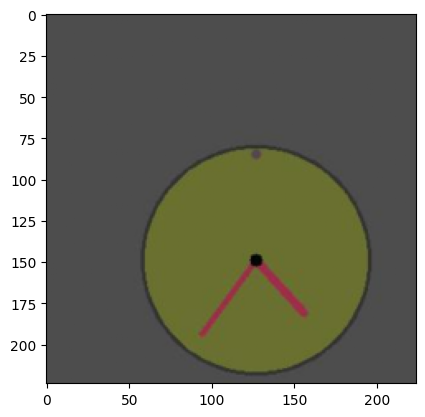

In [17]:
i=13
inp = test_dataset.__getitem__(i)[0]
print(test_dataset.__getitem__(i)[1])
plt.imshow(inp.permute(1,2,0))

In [18]:
from glob import glob

import matplotlib.pyplot as plt

import os

from PIL import Image

from sklearn.metrics import accuracy_score, recall_score

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torchvision import datasets

import warnings
warnings.filterwarnings("ignore")


In [19]:
def train_test_loop(model, num_epochs, train_loader, test_loader, criterion, optimizer, device):
    #shifting the model to device
    model.to(device)
    Loss = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            #shifting the inputs and the labels to same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            #resetting the gradient values
            optimizer.zero_grad()

            #computing the model output for the datapoint
            outputs = model(inputs)

            #computing the loss
            loss = criterion(outputs, labels)

            #backpropagating the loss
            loss.backward()

            #updating the gradients
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        Loss.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    #evaluation
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    recall = recall_score(all_labels, all_predictions, average='weighted')
    accuracy = correct/total
    return model, Loss, accuracy, recall

In [20]:
# Function for plotting the training and validation loss
def plot_train_loss(training_loss, title):
    plt.plot(training_loss, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

## Model loading and training

In [21]:
#loading pre-trained ResNet18
resnet = torchvision.models.resnet18(pretrained=True)

#freeze all layers except the last one
for name, param in resnet.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = True

#modifying the last layer to fit the number of classes in your dataset
num_classes = 60 # for minutes
num_classes = 12 # for hour

resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

#defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
trained_model1, loss1, acc1, recall1 = train_test_loop(resnet, num_epochs, train_data_loader, test_data_loader, criterion, optimizer, device)

Epoch [1/2], Loss: 0.9742
Epoch [2/2], Loss: 0.2036


In [23]:
print(acc1)

0.96436


tensor([1])
tensor([1], device='cuda:0')


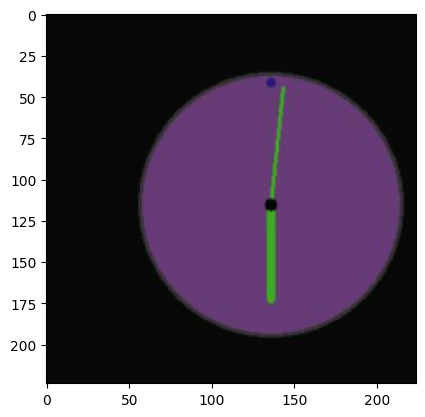

In [24]:
#test loader for saliency map with batch size of 1
test_loader2 = DataLoader(test_dataset, batch_size=1, shuffle=True)
inp = 0
with torch.no_grad():
	for inputs, labels in test_loader2:
		inputs, labels = inputs.to(device), labels.to(device)
		inp = inputs
		outputs = trained_model1(inputs)
		_, predicted = torch.max(outputs.data, 1)
		print(predicted.detach().cpu())
		print(labels)
		break


inp = inp[0].detach().cpu()

plt.imshow(inp.permute(1,2,0))
